In [1]:
import os
import pickle
import tqdm

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(1);

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")


from utils import create_dataloader
# from cgan import Generator, Discriminator

/global/home/users/xju/miniconda3/envs/pyG-1.12.1/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = "/global/home/users/xju/projects/herwig/data"
filename = os.path.join(data_path, "allHadrons_mode4_with_quark_with_pert.npz")
org_filename = os.path.join(data_path, "cluster_ML_allHadrons.txt")

# Hadron types

In [3]:
from utils import read_dataframe, split_to_float

In [4]:
df = read_dataframe(org_filename, ";", 'python')
q1,q2,c,h1,h2 = [split_to_float(df[idx]) for idx in range(5)]

In [5]:
h1_type, h2_type = h1[[0]], h2[[0]]

In [6]:
fontsize = 16
def plot_counts(array: np.ndarray):
    types, counts = np.unique(array, return_counts=True)
    num_types = len(types)
    tot_cnts = np.sum(counts)
    xvals = np.arange(num_types)
    
    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(xvals, counts/tot_cnts, s=2.)

    ax.set_xticklabels([])
    ax.set_xlabel("hadron type", fontsize=fontsize)
    print(f"total {num_types} hadrons in the final state")
    return types.astype(np.int64), num_types

total 270 hadrons in the final state


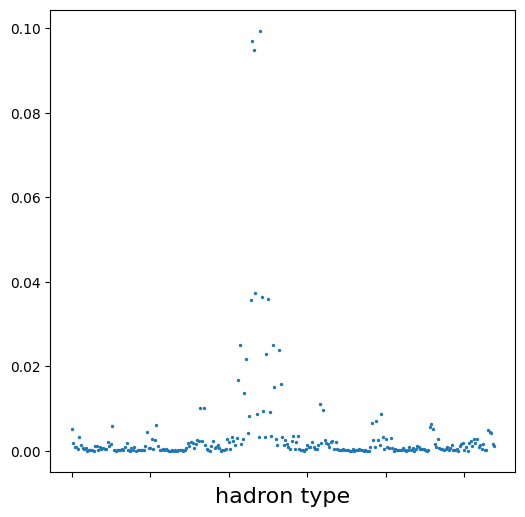

In [7]:
hadron_types = plot_counts(np.concatenate([h1_type, h2_type], axis=0))

## Hadron type embedding

In [8]:
embed_dim = 10
hadron_pids, num_hadron_types = hadron_types
pids_to_ix = {pids: i for i, pids in enumerate(hadron_pids)}

pickle.dump(pids_to_ix, open("pids_to_ix.pkl", "wb"))

In [9]:
type_embedding = nn.Embedding(num_hadron_types, embed_dim)

In [10]:
lookup_tensor = torch.tensor([pids_to_ix[111]], dtype=torch.long)
pion_embed = type_embedding(lookup_tensor)
print(pion_embed)

tensor([[ 0.3388, -0.7186, -0.5009,  0.7134,  2.3605, -0.1826,  0.5411, -0.7188,
         -0.1218,  0.3274]], grad_fn=<EmbeddingBackward0>)


# GAN with hadron type embedding

Read the input data

In [11]:
batch_size = 10
num_workers = 2

train_loader, test_loader, xlabels = create_dataloader(filename, batch_size, num_workers)

(7809, 4) (7809, 8)


In [12]:

num_layers = 2
hidden_dim = 64
noise_dim = 16
num_max_hadrons = 2

batch = next(iter(train_loader))
cond_dim = batch[0].shape[1]
output_dim = batch[1].shape[1] - 2
print("conditional dimension: ", cond_dim)
print("output dimension: ", output_dim)

conditional dimension:  8
output dimension:  2


In [13]:

class Generator(nn.Module):
    """Generator for the GAN"""
    def __init__(self, noise_dim: int, cond_dim: int, output_dim: int,
                 num_hadron_types: int, num_layers: int, hidden_dim: int,
                 num_max_hadrons: int = 2):       
        super(Generator, self).__init__()
        layer_list = []
        for i in range(num_layers):
            if i == 0:
                layer_list.append(nn.Linear(noise_dim + cond_dim, hidden_dim))
            else:
                layer_list.append(nn.Linear(hidden_dim, hidden_dim))
            layer_list.append(nn.LeakyReLU(0.2))
        
        layer_list.append(nn.Linear(hidden_dim, output_dim+num_hadron_types*num_max_hadrons))
        self.model = nn.Sequential(*layer_list)
        

    def forward(self, x):
        return self.model(x)
    
    
class Discriminator(torch.nn.Module):
    """Discriminator for the GAN"""
    def __init__(self, input_dim: int, cond_dim: int,
                 num_hadron_types: int, 
                 num_layers: int, hidden_dim: int,
                 num_max_hadrons: int = 2):
        super(Discriminator, self).__init__()
        layer_list = []
        for i in range(num_layers):
            if i == 0:
                layer_list.append(torch.nn.Linear(cond_dim + input_dim +  num_hadron_types * num_max_hadrons, hidden_dim))
            else:
                layer_list.append(torch.nn.Linear(hidden_dim, hidden_dim))
            layer_list.append(torch.nn.LeakyReLU(0.2))
        
        layer_list.append(torch.nn.Linear(hidden_dim, 1))
        layer_list.append(nn.Sigmoid())
        self.model = torch.nn.Sequential(*layer_list)
        
    
    def forward(self, x):
        return self.model(x)

In [14]:
generator = Generator(noise_dim, cond_dim, output_dim, num_hadron_types, num_layers, hidden_dim, num_max_hadrons).to(device)
discriminator = Discriminator(output_dim, cond_dim, num_hadron_types, num_layers, hidden_dim, num_max_hadrons).to(device)

In [15]:
noise = torch.randn(batch_size, noise_dim).to(device)
x, y = batch
x, y = x.to(device), y.to(device)
x_gen = torch.concat([x, noise], dim=1).to(device)

fake = generator(x_gen)

x_disc = torch.cat([x, fake], dim=1).to(device)
score = discriminator(x_disc)

In [21]:
opt_gen = optim.Adam(generator.parameters(), lr=0.002)
opt_disc = optim.Adam(discriminator.parameters(), lr=0.005)

criterion = nn.BCELoss()

In [19]:
def train():
    real_label = 1
    fake_label = 0
    
    tot_loss_gen = 0
    tot_loss_disc = 0
    num_batches = 0
    for batch in train_loader:
        num_batches += 1
        x, y = batch
        x, y = x.to(device), y.to(device)
        ##  Train discriminator with all-real batch
        discriminator.zero_grad()

        target_hadron_types = y[:, 2:].reshape(-1).long()
        target_hadron_types_idx = torch.from_numpy(np.array(
            [pids_to_ix[int(pid)] for pid in target_hadron_types]))
        
        num_evts = y.shape[0]

        true_hadron_types = torch.abs(F.one_hot(target_hadron_types_idx, num_classes=num_hadron_types) \
            - torch.rand(num_evts*num_max_hadrons, num_hadron_types)*0.001).reshape(num_evts, -1).to(device)
        x_truth = torch.cat([x, y[:, :2], true_hadron_types], dim=1)
        score_truth = discriminator(x_truth).squeeze()
        label = torch.full((num_evts,), real_label, dtype=torch.float, device=device)
        loss_real = criterion(score_truth, label)

        loss_real.backward()

        ## Train discriminator with all-fake batch
        noise = torch.randn(num_evts, noise_dim).to(device)
        x_fake = torch.concat([x, noise], dim=1)
        fake = generator(x_fake)

        x_generated = torch.cat([x, fake], dim=1)
        score_fakes = discriminator(x_generated.detach()).squeeze()
        label.fill_(fake_label)
        loss_fake = criterion(score_fakes, label)
        loss_fake.backward()
        loss_disc = loss_real + loss_fake
        ## Update discriminator
        opt_disc.step()


        ## Train generator
        generator.zero_grad()
        label.fill_(real_label)
        score_fakes = discriminator(x_generated).squeeze()
        loss_generator = criterion(score_fakes, label)
        loss_generator.backward()
        opt_gen.step()
        
        tot_loss_gen += loss_generator.item()
        tot_loss_disc += loss_disc.item()
        
    return tot_loss_gen/num_batches, tot_loss_disc/num_batches

In [22]:
num_epochs = 200

writer = SummaryWriter()
writer.add_graph(generator, x_gen)
writer.add_graph(discriminator, x_disc)

with tqdm.trange(num_epochs, disable=False) as t0:
    for _ in t0:
        # training
        loss_gen, loss_disc = train()
        writer.add_scalar("Generator Loss", loss_gen, _)
        writer.add_scalar("Discriminator Loss", loss_disc, _)
        
        metric = dict(lossG=loss_gen, lossD=loss_disc)
        
        # validation <TODO>
        t0.set_postfix(**metric)

 14%|█▎        | 27/200 [01:27<09:19,  3.23s/it, lossD=100, lossG=0]     


KeyboardInterrupt: 